Training code

In [2]:
import os
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import gradio as gr

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CuDNN optimizations
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# Dataset paths
base_dir = "/home/rishit/cv_deepfake/"
train_csv = os.path.join(base_dir, "train_labels.csv")
valid_csv = os.path.join(base_dir, "valid_labels.csv")
test_csv = os.path.join(base_dir, "test_labels.csv")

# Custom dataset class
class DeepfakeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = int(self.data.iloc[idx, 1])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = DeepfakeDataset(train_csv, transform)
valid_dataset = DeepfakeDataset(valid_csv, transform)
test_dataset = DeepfakeDataset(test_csv, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6, pin_memory=True)

# Model initializer
def get_model(model_name):
    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    return model.to(device)

# Model training function
def train_model(model_name, epochs=10):
    start_time = time.time()

    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = torch.amp.GradScaler()
    best_val_loss = float("inf")
    patience = 5
    patience_counter = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
            progress.set_postfix(loss=running_loss / (total // 32 + 1), acc=100 * correct / total)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(valid_loader))
        val_accs.append(100 * correct / total)

        print(f"\nEpoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Save the final model
    torch.save(model.state_dict(), f"final_{model_name}.pth")

    # Plot training history
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{model_name.upper()} - Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Validation Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title(f"{model_name.upper()} - Accuracy")

    plt.tight_layout()
    plt.show()

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

    return model


/home/rishit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


Testing Code

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def test_model(model_name):
    model = get_model(model_name)
    model.load_state_dict(torch.load(f"final_{model_name}.pth", map_location=device))
    model.eval()

    total, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"\nTest Accuracy for {model_name}: {accuracy:.2f}%")

    # Visualize confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Display detailed classification metrics
    print("\nDetailed Classification Metrics:")
    print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

    return accuracy



Prediction Code

In [4]:
def predict_image(image, model_name="efficientnet_b0"):
    model = get_model(model_name)
    model.load_state_dict(torch.load(f"final_{model_name}.pth", map_location=device))
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = image.convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1)[0]
        pred_class = torch.argmax(probs).item()
        confidence_real = probs[0].item() * 100
        confidence_fake = probs[1].item() * 100

    label = "Real" if pred_class == 0 else "Fake"
    return f"Prediction: {label}\nReal: {confidence_real:.2f}%\nFake: {confidence_fake:.2f}%"


# Gradio UI
gr_interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Text(label="Prediction"),
    title="Deepfake Image Classifier",
    description="Upload an image to classify it as Real or Fake using EfficientNet-B0.",
    allow_flagging="never"
)


/home/rishit/.local/lib/python3.10/site-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(



Training EFFICIENTNET_B0 Model...



/home/rishit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [1/10] - Train Loss: 0.1751, Train Acc: 92.69%, Val Loss: 0.0707, Val Acc: 97.48%



Epoch [2/10] - Train Loss: 0.0580, Train Acc: 97.80%, Val Loss: 0.0531, Val Acc: 98.12%



Epoch [3/10] - Train Loss: 0.0380, Train Acc: 98.58%, Val Loss: 0.0390, Val Acc: 98.66%



Epoch [4/10] - Train Loss: 0.0281, Train Acc: 99.01%, Val Loss: 0.0340, Val Acc: 98.72%



Epoch [5/10] - Train Loss: 0.0235, Train Acc: 99.15%, Val Loss: 0.0885, Val Acc: 97.17%



Epoch [6/10] - Train Loss: 0.0207, Train Acc: 99.23%, Val Loss: 0.0337, Val Acc: 98.77%



Epoch [7/10] - Train Loss: 0.0187, Train Acc: 99.34%, Val Loss: 0.0427, Val Acc: 98.53%



Epoch [8/10] - Train Loss: 0.0166, Train Acc: 99.40%, Val Loss: 0.0314, Val Acc: 98.80%



Epoch [9/10] - Train Loss: 0.0158, Train Acc: 99.42%, Val Loss: 0.0458, Val Acc: 98.32%



Epoch [10/10] - Train Loss: 0.0142, Train Acc: 99.52%, Val Loss: 0.0397, Val Acc: 98.81%


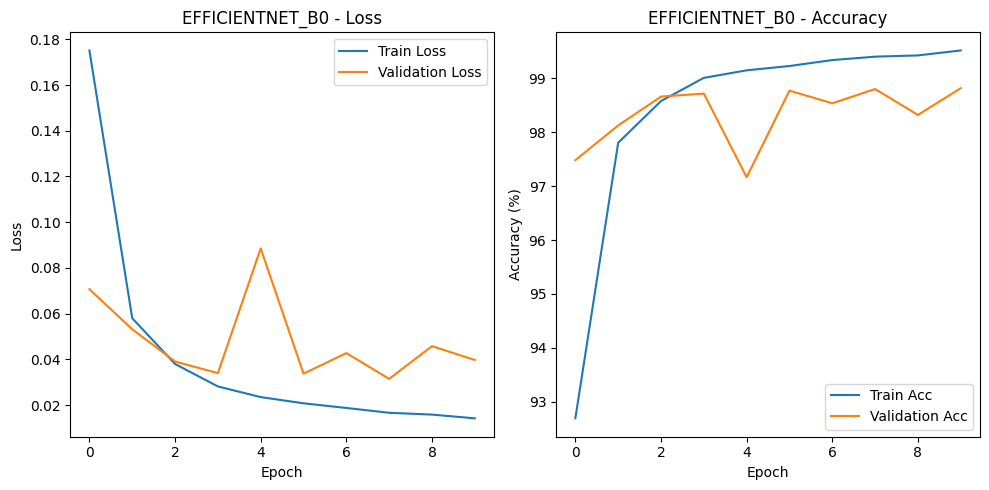

Total training time: 5980.57 seconds (99.68 minutes)

Testing EFFICIENTNET_B0 Model...



/tmp/ipykernel_1520/2100803725.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"final_{model_name}.pth", map_location=device))
Evaluati


Test Accuracy for efficientnet_b0: 98.84%


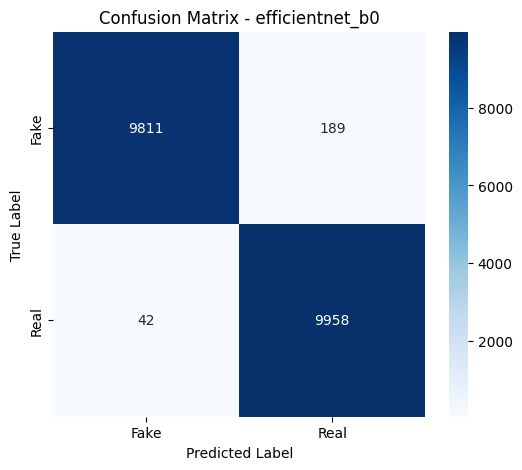


Detailed Classification Metrics:
              precision    recall  f1-score   support

        Fake       1.00      0.98      0.99     10000
        Real       0.98      1.00      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


/home/rishit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1520/3470297224.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

In [4]:
# Run training, testing, and Gradio
if __name__ == "__main__":
    model_name = "efficientnet_b0"
    print(f"\nTraining {model_name.upper()} Model...\n")
    trained_model = train_model(model_name)

    print(f"\nTesting {model_name.upper()} Model...\n")
    test_model(model_name)

    gr_interface.launch()

Run Web Interface

In [5]:
gr_interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


/home/rishit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_49717/3390912014.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.